© British Crown Copyright 2017-2025, Met Office. Please see LICENSE.md for license details.

In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from tqdm import tqdm

In [2]:
%run Download_Data.py

2024-10-11 14:01:48,482 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-10-11 14:01:48,484 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informative page](https://confluence.ecmwf.int/x/uINmFw) for guidance.
2024-10-11 14:01:48,484 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-10-11 14:01:48,485 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-10-11 14:01:48,487 WARNING [2024-06-16T

c729cbefb5b3bc08b3967416cccf55c0.grib:   0%|          | 0.00/856M [00:00<?, ?B/s]

In [3]:
# Determine the device to use
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS device


In [4]:
# Load the data
file_path = "./data/download.grib"

dataset = xr.load_dataset(file_path)
dataset

Ignoring index file './data/download.grib.5b7b6.idx' older than GRIB file
skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/data_readiness_era5/lib/python3.12/site-packages/cfgrib/dataset.py", line 721, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/homebrew/anaconda3/envs/data_readiness_era5/lib/python3.12/site-packages/cfgrib/dataset.py", line 639, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1693526400, 1693530000, 1693533600, 1693537200, 1693540800,
       1693544400, 1693548000, 1693551600, 1693555200, 1693558800,
       1693562400, 1693566000, 1693569600, 1693573200, 1693576800,
       1693580400, 1693584000, 1693587600, 1693591200, 1693594800,
       1693598400, 1693602000, 1693605600, 1693609200, 1693612800,
       1693616400, 1693620000, 1693623600

<xarray.Dataset> Size: 1GB
Dimensions:     (time: 72, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 576B 2023-09-01 ... 2023-09-03T23:00:00
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] 576B 2023-09-01 ... 2023-09-03T23:00:00
Data variables:
    u10         (time, latitude, longitude) float32 299MB -0.9608 ... 3.67
    v10         (time, latitude, longitude) float32 299MB -4.314 ... -0.7297
    d2m         (time, latitude, longitude) float32 299MB 271.8 271.8 ... 206.7
    t2m         (time, latitude, longitude) float32 299MB 272.3 272.3 ... 211.1
    sp          (time, latitude, longitude) float32 299MB 9.986e+04 ... 6.772...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-11T14:06 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
# Define hyper parameters
config = {
    'batch_size': 8,
    'num_epochs': 50,
    'learning_rate': 1e-3,
    'test_size': 0.2,
}

In [6]:
data_vars = list(dataset.data_vars)
data_vars

['u10', 'v10', 'd2m', 't2m', 'sp']

In [7]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Crop the dataset to the desired latitude range
cropped_dataset = dataset.isel(latitude=slice(0, 720))

# Extract variables from dataset and stack them into a numpy array (time, lat, long, vars)
data = np.stack([cropped_dataset[var].values for var in data_vars], axis=-1)

# Reshape the data for StandardScaler (it expects 2D, so combine lat, long, and vars)
# Reshape to (time, lat*long*vars) for scaling, later we'll reshape back
n_time, n_lat, n_long, n_vars = data.shape
reshaped_data = data.reshape(n_time, -1)

# Fit and transform the data using StandardScaler
scaled_data = scaler.fit_transform(reshaped_data)

# Reshape back to original (time, lat, long, vars) shape
standardized_data = scaled_data.reshape(n_time, n_lat, n_long, n_vars)

# Split the data into training and test sets
X_train, X_test = train_test_split(standardized_data, test_size=config['test_size'])

# Convert to PyTorch tensors and change dimensions to (time, vars, lat, long)
tensor_data_train = torch.Tensor(X_train).permute(0, 3, 1, 2)
tensor_data_test = torch.Tensor(X_test).permute(0, 3, 1, 2)

# Create TensorDataset
tensor_dataset_train = TensorDataset(tensor_data_train)
tensor_dataset_test = TensorDataset(tensor_data_test)

# Create DataLoaders
train_loader = DataLoader(tensor_dataset_train, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(tensor_dataset_test, batch_size=config['batch_size'], shuffle=True)

In [8]:
# Define the model
class ConvAutoencoder(nn.Module):
    def __init__(self, input_size):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_size[0], 16, kernel_size=3, stride=(1,2), padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(16, input_size[0], kernel_size=3, stride=(1,2), padding=1, output_padding=(0, 1)),  
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

dummy_input= next(iter(test_loader))[0].to(device)
model = ConvAutoencoder(dummy_input[0].shape).to(device)
print("Input shape:", dummy_input.shape)
print("Output shape:", model(dummy_input).shape)

Input shape: torch.Size([8, 5, 720, 1440])
Output shape: torch.Size([8, 5, 720, 1440])


In [9]:
%%time

# Define the loss function and the optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

num_epochs = config['num_epochs']

# Training loop
for epoch in range(num_epochs):
    model.train()  
    train_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{config['num_epochs']-1}", leave=False)
    for data in progress_bar:
        inputs = data[0].to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Reconstruction loss
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Train Loss': loss.item()})

    # Calculate average training loss
    train_loss /= len(train_loader)

    # Evaluate on the test set
    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  
        for data in test_loader:
            inputs = data[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            test_loss += loss.item()

    # Calculate average test loss
    test_loss /= len(test_loader)

    # Write test loss to tensorboard

    print(f"Epoch [{epoch}/{num_epochs-1}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

print("Training completed.")

Epoch [0/49], Train Loss: 0.9977, Test Loss: 1.0826


Epoch [1/49], Train Loss: 0.9588, Test Loss: 0.9758


Epoch [2/49], Train Loss: 0.8206, Test Loss: 0.8219


Epoch [3/49], Train Loss: 0.7033, Test Loss: 0.7014


Epoch [4/49], Train Loss: 0.5980, Test Loss: 0.6246


Epoch [5/49], Train Loss: 0.5507, Test Loss: 0.5616


Epoch [6/49], Train Loss: 0.4715, Test Loss: 0.4885


Epoch [7/49], Train Loss: 0.4150, Test Loss: 0.4348


Epoch [8/49], Train Loss: 0.3870, Test Loss: 0.3724


Epoch [9/49], Train Loss: 0.3307, Test Loss: 0.3335


Epoch [10/49], Train Loss: 0.2932, Test Loss: 0.2840


Epoch [11/49], Train Loss: 0.2462, Test Loss: 0.2515


Epoch [12/49], Train Loss: 0.2302, Test Loss: 0.2361


Epoch [13/49], Train Loss: 0.2118, Test Loss: 0.2213


Epoch [14/49], Train Loss: 0.1912, Test Loss: 0.1959


Epoch [15/49], Train Loss: 0.1878, Test Loss: 0.2012


Epoch [16/49], Train Loss: 0.1657, Test Loss: 0.1664


Epoch [17/49], Train Loss: 0.1483, Test Loss: 0.1544


Epoch [18/49], Train Loss: 0.1362, Test Loss: 0.1384


Epoch [19/49], Train Loss: 0.1251, Test Loss: 0.1262


Epoch [20/49], Train Loss: 0.1229, Test Loss: 0.1214


Epoch [21/49], Train Loss: 0.1172, Test Loss: 0.1315


Epoch [22/49], Train Loss: 0.1188, Test Loss: 0.1484


Epoch [23/49], Train Loss: 0.1142, Test Loss: 0.1114


Epoch [24/49], Train Loss: 0.1023, Test Loss: 0.0980


Epoch [25/49], Train Loss: 0.0954, Test Loss: 0.0965


Epoch [26/49], Train Loss: 0.0928, Test Loss: 0.0936


Epoch [27/49], Train Loss: 0.0906, Test Loss: 0.0909


Epoch [28/49], Train Loss: 0.0873, Test Loss: 0.0914


Epoch [29/49], Train Loss: 0.0858, Test Loss: 0.0870


Epoch [30/49], Train Loss: 0.0851, Test Loss: 0.0859


Epoch [31/49], Train Loss: 0.0822, Test Loss: 0.0860


Epoch [32/49], Train Loss: 0.0812, Test Loss: 0.0821


Epoch [33/49], Train Loss: 0.0791, Test Loss: 0.0808


Epoch [34/49], Train Loss: 0.0772, Test Loss: 0.0807


Epoch [35/49], Train Loss: 0.0769, Test Loss: 0.0782


Epoch [36/49], Train Loss: 0.0751, Test Loss: 0.0764


Epoch [37/49], Train Loss: 0.0750, Test Loss: 0.0767


Epoch [38/49], Train Loss: 0.0727, Test Loss: 0.0744


Epoch [39/49], Train Loss: 0.0701, Test Loss: 0.0730


Epoch [40/49], Train Loss: 0.0705, Test Loss: 0.0747


Epoch [41/49], Train Loss: 0.0732, Test Loss: 0.0703


Epoch [42/49], Train Loss: 0.0708, Test Loss: 0.0723


Epoch [43/49], Train Loss: 0.0668, Test Loss: 0.0666


Epoch [44/49], Train Loss: 0.0660, Test Loss: 0.0681


Epoch [45/49], Train Loss: 0.0646, Test Loss: 0.0664


Epoch [46/49], Train Loss: 0.0625, Test Loss: 0.0636


Epoch [47/49], Train Loss: 0.0633, Test Loss: 0.0677


Epoch [48/49], Train Loss: 0.0621, Test Loss: 0.0619


Epoch [49/49], Train Loss: 0.0612, Test Loss: 0.0608
Training completed.
CPU times: user 18 s, sys: 30.1 s, total: 48.1 s
Wall time: 2min 9s


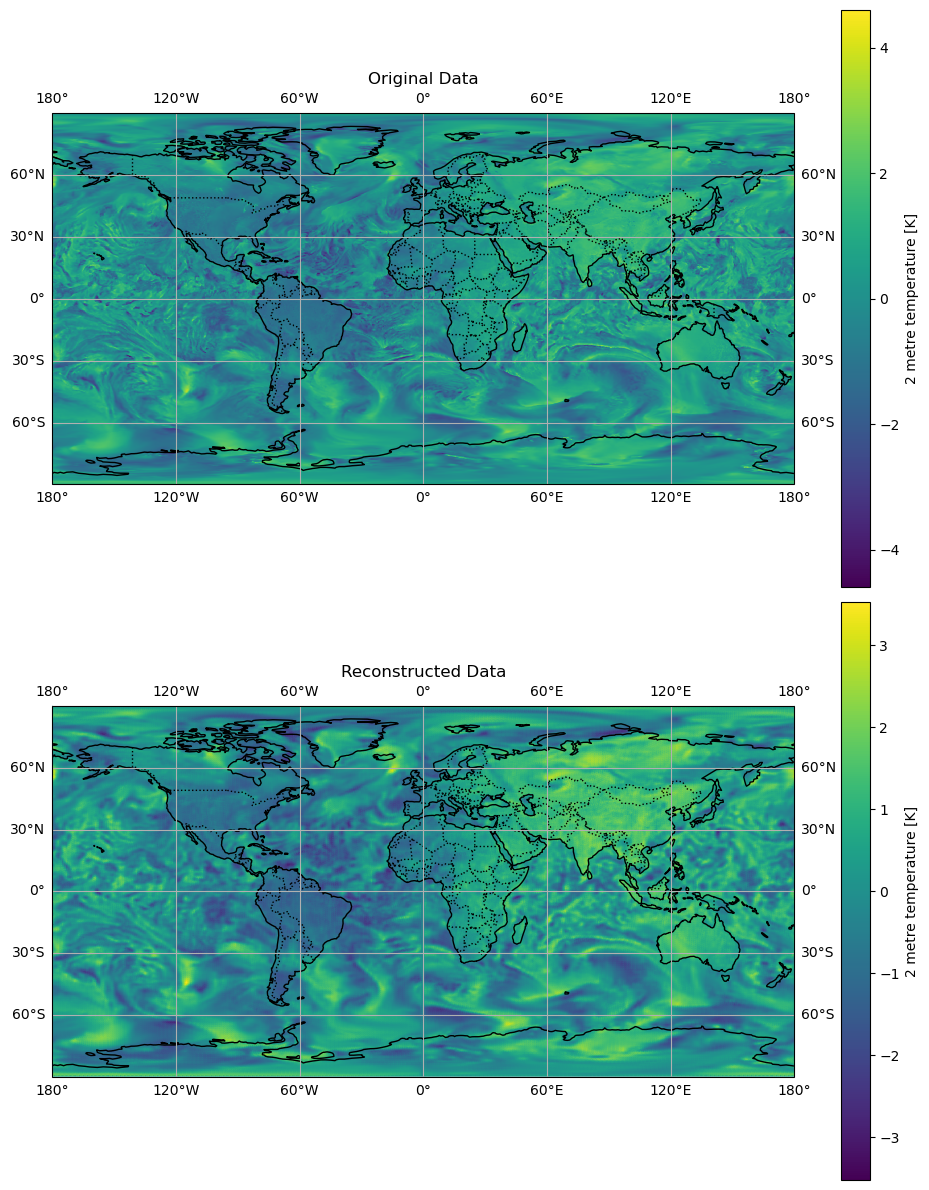

In [10]:
# Run the model on one example
test_data = next(iter(test_loader))[0].to(device)

# Set the model in evaluation mode and turn off gradient calculations
model.eval()
with torch.no_grad():
    # Pass the test data through the model to get the reconstruction
    reconstructed_data = model(test_data)

def data2xarray(dataset, data):
    for i, var in enumerate(dataset.data_vars):
        getattr(dataset, var).values = data[i]
    return dataset

# Create a figure with Cartopy projections for both subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Create the original and reconstructed xarray datasets
original_data_xr = data2xarray(cropped_dataset.isel(time=0).copy(), test_data[0].to('cpu'))
reconstructed_data_xr = data2xarray(cropped_dataset.isel(time=0).copy(), reconstructed_data[0].to('cpu'))

# Plot original data with Cartopy features
original_data_xr.t2m.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap='viridis')
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS, linestyle=':')
axes[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
axes[0].set_title('Original Data')

# Plot reconstructed data with Cartopy features
reconstructed_data_xr.t2m.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap='viridis')
axes[1].coastlines()
axes[1].add_feature(cfeature.BORDERS, linestyle=':')
axes[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
axes[1].set_title('Reconstructed Data')

# Display the plot
plt.tight_layout()
plt.show()
